#### Confounding variable analysis

In [510]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from scipy import stats
from IPython.display import display, HTML


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE 
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [511]:
folder = '/root/capsule/data/filtered_data_session/filtered_data_101724.csv' # Updated** as of 10/17/24
df = pd.read_csv(folder)

/tmp/ipykernel_19503/4128915244.py:2: DtypeWarning: Columns (6,7,8,26,27,28,29,30,146,147,148,149,150,151,152,153,154,155,156,157,158) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(folder)


In [512]:
# Let's look at individual trainer foraging performance scores first 

indiv_df = df[['subject_id', 'user_name', 'foraging_performance', 'session_date', 'curriculum_name']]
# Convert session_date to dates 
indiv_df['session_date'] = pd.to_datetime(indiv_df['session_date'])

# Filter for uncoupled baiting
#indiv_df = indiv_df[indiv_df['curriculum_name'].isin(['Uncoupled Baiting'])]

/tmp/ipykernel_19503/4112454690.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_df['session_date'] = pd.to_datetime(indiv_df['session_date'])


In [513]:
# Create day index and fill missing days with 0 values 

def fill_missing_days(df):
    df['session_date'] = pd.to_datetime(df['session_date'])
    # Sort values
    df = df.sort_values(by=['subject_id', 'session_date'])

    filled_df_list = []

    # Process each subject individually
    for subject, group in df.groupby('subject_id'):
        # Calculate the number of days since the first session for each row
        group = group.copy()
        group['day_index'] = (group['session_date'] - group['session_date'].min()).dt.days

        # Create df that spans the entire date range from min to max day_index
        full_day_range = pd.DataFrame({
            'day_index': np.arange(group['day_index'].min(), group['day_index'].max() + 1)
        })

        # Merge with the original group, filling missing days with NaN for performance
        full_group = full_day_range.merge(group, on='day_index', how='left')

        # Fill missing performance values with 0
        full_group['foraging_performance'].fillna(0, inplace=True)

        # Carry forward subject_id, user_name, curriculum_name, and fill NaN dates with incremented dates
        full_group['subject_id'] = subject
        full_group['user_name'] = group['user_name'].iloc[0]
        full_group['curriculum_name'] = group['curriculum_name'].iloc[0]
        full_group['session_date'] = pd.date_range(start=group['session_date'].min(), periods=len(full_group))

        # Append the filled group to the list of results
        filled_df_list.append(full_group)

    # Concatenate all the filled DataFrames
    filled_df = pd.concat(filled_df_list, ignore_index=True)

    return filled_df


In [514]:
filled_indiv_df = fill_missing_days(indiv_df)

print(filled_indiv_df.shape)

/tmp/ipykernel_19503/280478477.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['session_date'] = pd.to_datetime(df['session_date'])


(9012, 6)


In [515]:
# Abbreviate for readability in plots 
#indiv_df['date'] = indiv_df['session_date'].dt.strftime('%b %d')

# Filter for selected user
user = 'Avalon Amaya'

bt_df = filled_indiv_df
#bt_df = filled_indiv_df[filled_indiv_df['user_name'] == user]
bt_df = bt_df.sort_values(by=['subject_id', 'session_date'])
print(bt_df.shape)
#display(HTML(bt_df.to_html()))

(9012, 6)


In [516]:
# Create pivot tables for average foraging performance with dims: (subject x time)

bt_pivot_table = bt_df.pivot_table(
    values='foraging_performance', 
    index='subject_id', 
    columns='day_index',
    aggfunc='mean',
    fill_value=0
)

In [517]:
# Scaling average pivot table values and create new dataframe
#scaler = StandardScaler()

#scaled_fp_values = scaler.fit_transform(bt_pivot_table.values)


bt_df = pd.DataFrame(bt_pivot_table.values, index=bt_pivot_table.index, columns=bt_pivot_table.columns)

#other_users_subjects = indiv_df[indiv_df['user_name'] != user]['subject_id'].unique()

#bt_df['trained_by_others'] = bt_df.index.isin(other_users_subjects)

#bt_df = bt_df[bt_df['trained_by_others'] == False]

bt_df.head(20)

day_index,0,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
subject_id,,,,,,,,,,,,,,,,,,,,,
662914,0.63,0.00,0.78,0.83,0.00,0.00,0.66,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
663612,0.74,0.00,0.63,0.52,0.00,0.00,0.50,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
668463,0.59,0.00,0.00,0.68,0.58,0.00,0.42,0.55,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
668546,0.71,0.00,0.52,0.44,0.00,0.00,0.65,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
668548,0.65,0.00,0.63,0.72,0.00,0.00,0.85,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
668551,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
671087,0.59,0.00,0.00,0.00,0.69,0.59,0.79,0.66,0.49,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
676746,0.40,0.45,0.47,0.39,0.00,0.00,0.68,0.74,0.45,0.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
676747,0.41,0.00,0.25,0.23,0.00,0.00,0.00,0.50,0.40,0.36,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


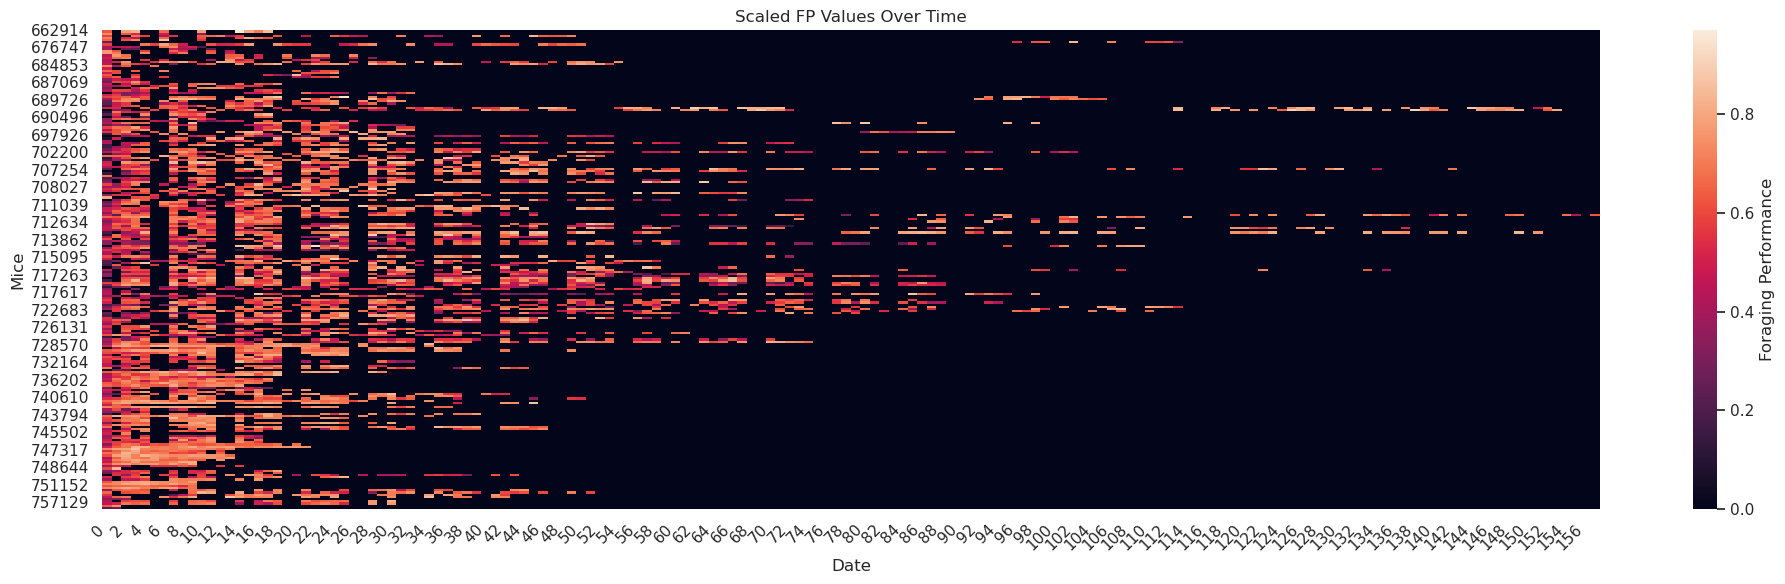

In [518]:
# Exclude float column 
#bt_df = bt_df.drop(columns='curriculum_name')

# Plot foraging performance heatmap
sns.set_theme()

plt.figure(figsize=(20,6))
sns.heatmap(data=bt_df, cbar_kws={'label': 'Foraging Performance'})
plt.xticks(rotation=45, ha='right')
plt.title('Scaled FP Values Over Time')
plt.xlabel('Date')
plt.ylabel('Mice')

plt.tight_layout()

plt.show()

In [519]:
def analyze_subject(row):

    # Find non-zero values and idxs
    non_zero = row[row != 0]
    non_zero_idx = np.where(row != 0)[0]

    if len(non_zero) <= 1:
        return {'subject_id': row.name, 'continuous': True, 'breaks': 0, 'break_length': []}
    
    # Find gaps between breaks 
    gaps = np.diff(non_zero_idx)

    # If all gaps = 1, then continous else
    if np.all(gaps == 1):
        return {'subject_id': row.name, 'continuous': True, 'breaks': 0, 'break_length': []}

    # Count gaps and lengths 
    breaks = np.sum(gaps > 1)
    break_length = gaps[gaps > 1] - 1

    return {
        'subject_id': row.name,
        'continuous': False,
        'breaks': breaks,
        'break_length': break_length.tolist()
    }

In [520]:
results = bt_df.apply(analyze_subject, axis=1)

results_df = pd.DataFrame(results.tolist())

continuous_subjects = results_df[results_df['continuous']]['subject_id'].tolist()
discontinuous_subjects = results_df[~results_df['continuous']]

print("Subjects with continuous foraging performance:")
print(continuous_subjects)
print("\nSubjects with breaks in foraging performance:")
for _, row in discontinuous_subjects.iterrows():
    print(f"Subject {row['subject_id']}:")
    print(f"  Number of breaks: {row['breaks']}")
    print(f"  Break lengths: {row['break_length']}")
    print()

Subjects with continuous foraging performance:
[684874, 685983, 686868, 689329, 699979, 707524, 736199, 736201, 736202, 736203, 736205, 741212, 747315, 747316, 747320, 747886, 747890, 747893, 748644, 751147, 751151, 751152, 751153, 754375, 764769, 764787]

Subjects with breaks in foraging performance:
Subject 662914:
  Number of breaks: 4
  Break lengths: [1, 2, 3, 3]

Subject 663612:
  Number of breaks: 3
  Break lengths: [1, 2, 3]

Subject 668463:
  Number of breaks: 11
  Break lengths: [2, 1, 2, 3, 2, 2, 3, 2, 3, 2, 2]

Subject 668546:
  Number of breaks: 4
  Break lengths: [1, 2, 3, 3]

Subject 668548:
  Number of breaks: 3
  Break lengths: [1, 2, 3]

Subject 668551:
  Number of breaks: 5
  Break lengths: [95, 1, 2, 3, 3]

Subject 671087:
  Number of breaks: 8
  Break lengths: [3, 2, 2, 3, 3, 2, 2, 2]

Subject 676746:
  Number of breaks: 1
  Break lengths: [2]

Subject 676747:
  Number of breaks: 3
  Break lengths: [1, 3, 1]

Subject 680396:
  Number of breaks: 4
  Break lengths: [

In [521]:
def performance_difference(row):
    non_zero = row[row != 0]
    non_zero_idx = np.where(row != 0)[0]

    if len(non_zero_idx) <= 1:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'num_breaks': 0,
            'avg_break_length': 0
        }

    breaks = np.where(np.diff(non_zero_idx) > 1)[0]
    
    if len(breaks) == 0:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'num_breaks': 0,
            'avg_break_length': 0
        }

    differences = []
    break_lengths = []

    for i in range(len(breaks)):
        last_value_before = non_zero.iloc[breaks[i]]
        first_value_after = non_zero.iloc[breaks[i] + 1]
        
        # - differences = decrease in learning
        # + differences = increase in learning
        differences.append(first_value_after - last_value_before)

        break_length = non_zero_idx[breaks[i] + 1] - non_zero_idx[breaks[i]] - 1
        break_lengths.append(break_length)

    mean_difference = sum(differences) / len(differences)
    abs_difference = sum(differences)
    avg_break_length = sum(break_lengths) / len(break_lengths)

    return {
        'subject_id': row.name,
        'mean_performance_difference': mean_difference,
        'absolute_performance_difference': abs_difference,
        'num_breaks': len(breaks)
    }

In [522]:
def performance_difference(row):
    # Get the non-zero values and their indices (ignoring 0s)
    non_zero = row[row != 0]
    non_zero_idx = np.where(row != 0)[0]

    # If there are no or only one non-zero value, no breaks exist
    if len(non_zero_idx) <= 1:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'absolute_performance_difference': 0,
            'num_breaks': 0,
            'average_break_length': 0
        }

    # Find the indices where there are gaps (breaks in consecutive sessions)
    breaks = np.where(np.diff(non_zero_idx) > 1)[0]
    
    # If no breaks found, return the default values
    if len(breaks) == 0:
        return {
            'subject_id': row.name,
            'mean_performance_difference': 0,
            'absolute_performance_difference': 0,
            'num_breaks': 0,
            'average_break_length': 0
        }

    # Calculate performance differences across breaks
    differences = []
    break_lengths = []
    
    for i in range(len(breaks)):
        # Calculate the performance differences before and after the break
        last_value_before = non_zero.iloc[breaks[i]]
        first_value_after = non_zero.iloc[breaks[i] + 1]
        
        # Append the difference in performance
        differences.append(first_value_after - last_value_before)

        # Calculate the length of the break
        break_length = non_zero_idx[breaks[i] + 1] - non_zero_idx[breaks[i]] - 1
        break_lengths.append(break_length)

    # Compute the mean performance difference and the average break length
    mean_difference = sum(differences) / len(differences)
    abs_difference = sum(differences)
    average_break_length = sum(break_lengths) / len(break_lengths)

    return {
        'subject_id': row.name,
        'mean_performance_difference': mean_difference,
        'absolute_performance_difference': abs_difference,
        'num_breaks': len(breaks),
        'average_break_length': average_break_length
    }


In [523]:
results = bt_df.apply(performance_difference, axis=1)
results_df = pd.DataFrame(results.tolist())

In [524]:
# Clean 

cleaned_df = results_df[(results_df['mean_performance_difference'] != 0) | (results_df['num_breaks'] != 0)]

# Sort

cleaned_df = cleaned_df.sort_values('num_breaks', ascending=False)

# Reset index

cleaned_df.reset_index(drop = True)

pd.set_option('display.float_format', '{:.2f}'.format)
print(cleaned_df.to_string(index=False))
print(cleaned_df.shape)

 subject_id  mean_performance_difference  absolute_performance_difference  num_breaks  average_break_length
     711256                         0.00                             0.11          29                  3.45
     706893                         0.01                             0.19          29                  2.83
     713379                        -0.01                            -0.39          27                  3.19
     689799                         0.01                             0.31          25                  3.52
     689798                         0.01                             0.29          25                  3.60
     713377                        -0.00                            -0.00          24                  3.58
     716870                        -0.00                            -0.01          24                  4.08
     722679                         0.01                             0.24          24                  3.04
     722683                 

In [525]:
# Need to change the way I am visualising (axis prob)

<Axes: xlabel='num_breaks', ylabel='absolute_performance_difference'>

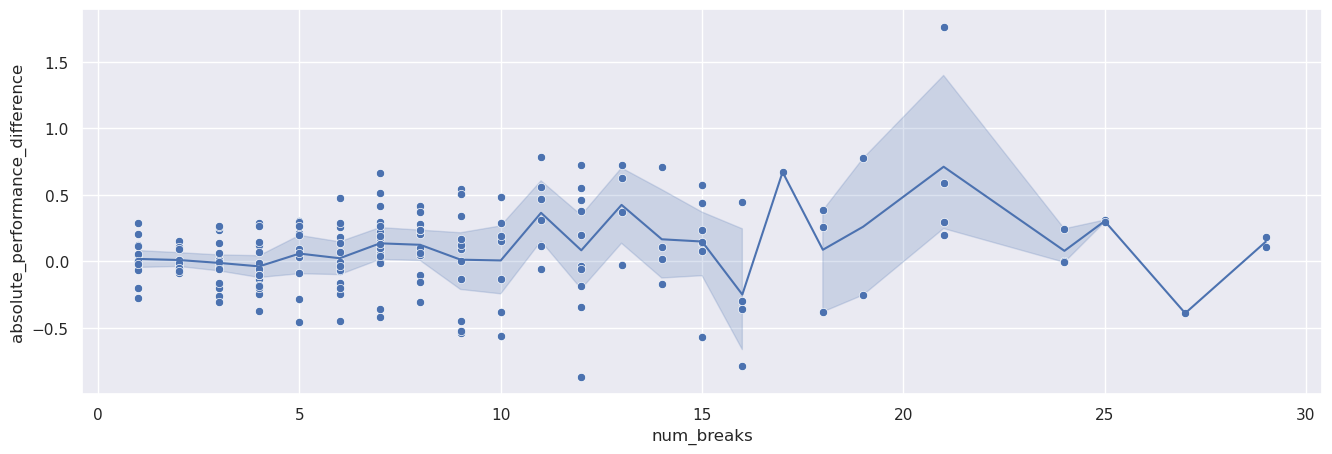

In [526]:
plt.figure(figsize=(16,5))

sns.lineplot(cleaned_df, x='num_breaks', y='absolute_performance_difference')
sns.scatterplot(cleaned_df, x='num_breaks', y='absolute_performance_difference')

<Axes: xlabel='average_break_length', ylabel='mean_performance_difference'>

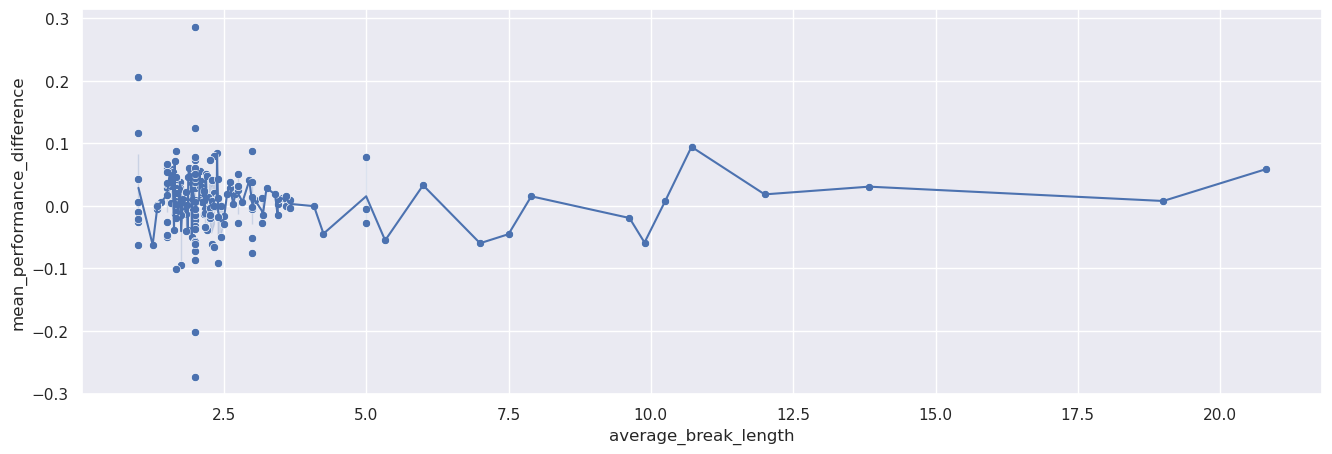

In [527]:
plt.figure(figsize=(16,5))

sns.lineplot(cleaned_df, x='average_break_length', y='mean_performance_difference')
sns.scatterplot(cleaned_df, x='average_break_length', y='mean_performance_difference')

In [528]:
from scipy.stats import pearsonr, spearmanr

# Correlation between number of breaks and performance difference
corr_pearson, p_value = pearsonr(cleaned_df['num_breaks'], cleaned_df['mean_performance_difference'])
corr_spearman, p_value_spearman = spearmanr(cleaned_df['num_breaks'], cleaned_df['mean_performance_difference'])

print(f"Pearson Correlation: {corr_pearson}, P-value: {p_value}")
print(f"Spearman Correlation: {corr_spearman}, P-value: {p_value_spearman}")


Pearson Correlation: 0.040400658562076204, P-value: 0.5769497477420149
Spearman Correlation: 0.09165023260815594, P-value: 0.20492500098851957


In [529]:
from scipy.stats import ttest_rel

before_value = cleaned_df['before_value'].tolist()
after_value = cleaned_df['after_value'].tolist()
break_length = cleaned_df['break_length'].tolist() 

# Assuming `before_gap_performance` and `after_gap_performance` hold performance values before and after each gap
t_stat, p_value = ttest_rel(before_value, after_value)

print(f"T-statistic: {t_stat}, P-value: {p_value}")


KeyError: 'before_value'

In [ ]:
import statsmodels.api as sm

# Fit linear regression model
X = cleaned_df[['num_breaks', 'break_length']]  # independent variables
X = sm.add_constant(X)  # add intercept
y = cleaned_df['mean_performance_difference']  # dependent variable

model = sm.OLS(y, X).fit()
print(model.summary())


                                 OLS Regression Results                                
Dep. Variable:     mean_performance_difference   R-squared:                       0.002
Model:                                     OLS   Adj. R-squared:                 -0.043
Method:                          Least Squares   F-statistic:                   0.04789
Date:                         Fri, 18 Oct 2024   Prob (F-statistic):              0.829
Time:                                 20:17:42   Log-Likelihood:                 53.921
No. Observations:                           24   AIC:                            -103.8
Df Residuals:                               22   BIC:                            -101.5
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------